## Домашняя работа #3.

Домашнее задание сдаётся в виде ссылки (с доступом комментатор или редактор) на Colab в опросе:
https://forms.gle/zemRsbegG9fQRVw76

Отправлять ссылку через форму нужно только один раз. Исправления вносятся в тот же ноутбук до хард-дедлайна и помечаются комментариями в коде и комментариями к соотвествующим ячейкам.

Материалы к домашке доступны по ссылке:
https://drive.google.com/drive/folders/1dNoAOMcrRyuf_3vS1LTPpdyrqYxgvPOy?usp=sharing



Большая домашка с увеличенным баллом и временем до дедлайна.
* Морфлогия.
* Фильтры габора.
* Цветовые гистрограммы.
* Гистограммы градиентов.


**Soft deadline: 25.03.2022 03:00:00 +0003 GMT**

**Hard deadline: 01.04.2022 03:00:00 +0003 GMT**

In [131]:
# ПРИМОНТИРУЙТЕ ДИСК К НОУТБУКУ
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
from pathlib import Path
# ИЗМЕНИТЕ ЭТОТ ПУТЬ НА ТОТ, КУДА ВЫ ПОЛОЖИЛИ МАТЕРИАЛЫ КУРСА
sources_path = Path('/content/drive/MyDrive/HSE/CV/cv3/materials') 

In [133]:
import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')

def pyplot(func):
    def make_pyplot_context(*args, **kwargs):
        plt.figure(figsize=kwargs.get('size', (10, 5)))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        return func(*args, **kwargs)
    return make_pyplot_context

@pyplot
def show_bgr(img, size=(10, 5)):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

@pyplot
def show_gray(img, size=(10, 5)):
    plt.imshow(img, cmap='gray')

def mse(img1, img2):
    return ((img1.astype(int) - img2.astype(int)) ** 2).mean()

    

# МОРФОЛОГИЯ

**1. (5 баллов)** Выделите в изображении $table.jpg$ границы таблицы с использованием морфологических операций. Результатом обработки должно бытьn изображение, в котором удален весь текст и оставлены только границы таблицы.

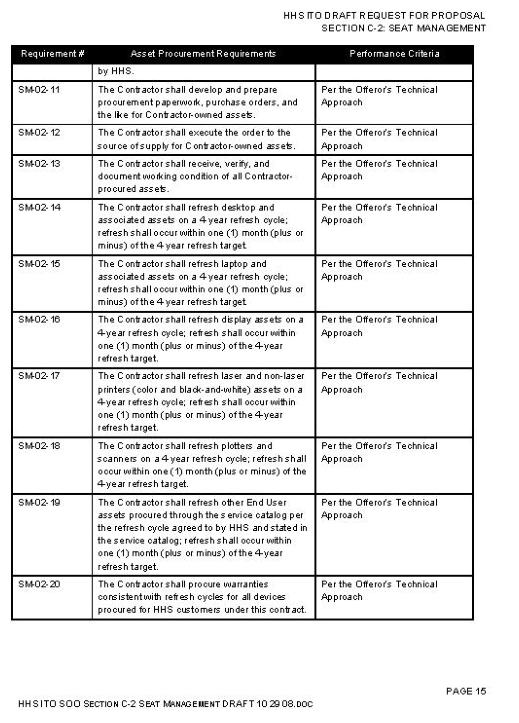

In [134]:
table = cv2.imread(str(sources_path / "table.jpg"), 0)
show_gray(table, size=(5, 10))

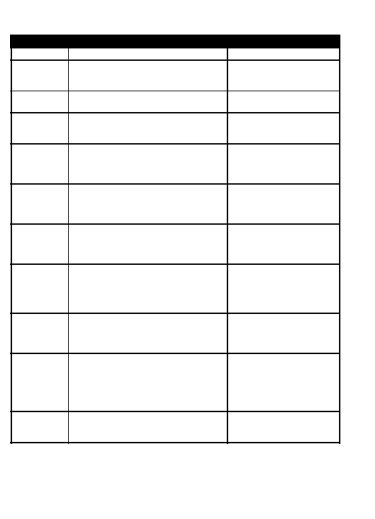

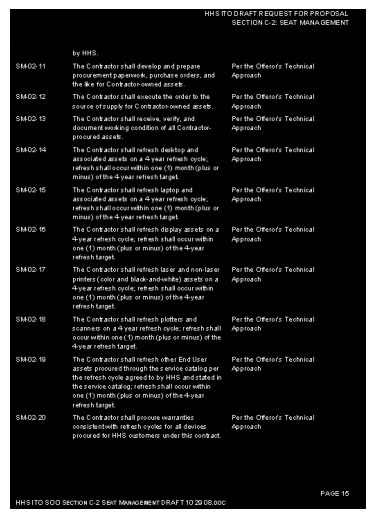

In [135]:
# инвертируем цвета, чтобы работать с черными линиями
image = cv2.bitwise_not(cv2.threshold(table,127,255,cv2.THRESH_BINARY)[1])

# оставим только вертикальные линии
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
remove_vertical = cv2.morphologyEx(image, cv2.MORPH_OPEN, vertical_kernel, iterations=1)

# оставим горизонтальные линии
horisontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
remove_horisontal = cv2.morphologyEx(image, cv2.MORPH_OPEN, horisontal_kernel, iterations=5)

# нарастим черную полоску обратно
square_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
black_line = cv2.morphologyEx(remove_horisontal, cv2.MORPH_CLOSE, square_kernel, iterations=2)

# соберем все вместе
no_text_table = cv2.bitwise_not(remove_vertical + black_line)
show_gray(no_text_table)
# увидим, что все полосы с исходными размерами
show_gray(cv2.bitwise_not(cv2.threshold(table,127,255,cv2.THRESH_BINARY)[1]) - cv2.bitwise_not(no_text_table))

**2. (5 баллов)** Для изображения $circles.jpg$ реализуйте морфологический алгоритм для построения трех изображений, которые бы содержали соответственно:

* только частицы, касающиеся краев изображения, 

* только группы перекрывающихся частиц,

* только одиночные круглые частицы.

Посчитайте число частиц и групп на каждом изображении. Раскрастье отдельные компоненты с помощью функции. 

<class 'numpy.ndarray'>


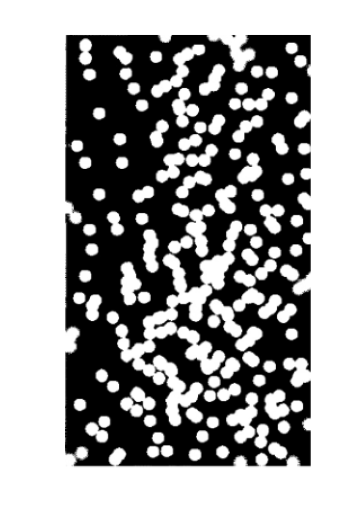

In [136]:
circles = cv2.imread(str(sources_path / "circles.png"), 0)
show_gray(circles)
print(type(circles))

In [137]:
# show_gray(circles[125:145, 105:125])

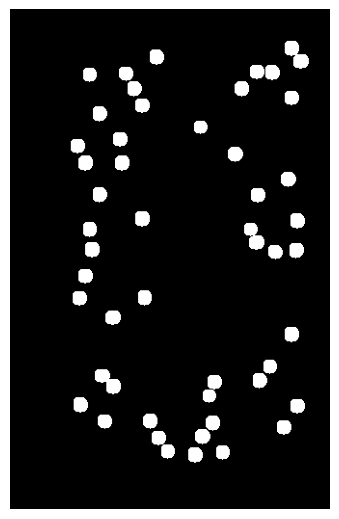

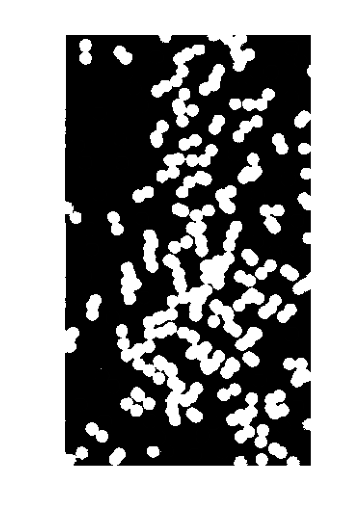

In [138]:
def sigle_circles(image, l=17, h=3):
    input_image = cv2.threshold(image,127,255,cv2.THRESH_BINARY)[1]

    kernel = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            if l//2-0.5 < np.linalg.norm([i-l//2, j-l//2]) <= l//2+0.5:
                kernel[i, j] = -1
            if np.linalg.norm([i-l//2, j-l//2]) <= h:
                kernel[i, j] = +1
    
    output_image = cv2.morphologyEx(input_image, cv2.MORPH_HITMISS, kernel)
    s = 14
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (s, s))
    cv2.dilate(output_image, element, dst=output_image)
    return kernel+1, cv2.convertScaleAbs(output_image)

cirles_bin = cv2.threshold(circles,127,255,cv2.THRESH_BINARY)[1]
kernel, alone_circles = sigle_circles(circles)
# show_gray(cirles_bin)
# show_gray(kernel)

show_gray(alone_circles)
show_gray(cirles_bin - alone_circles)

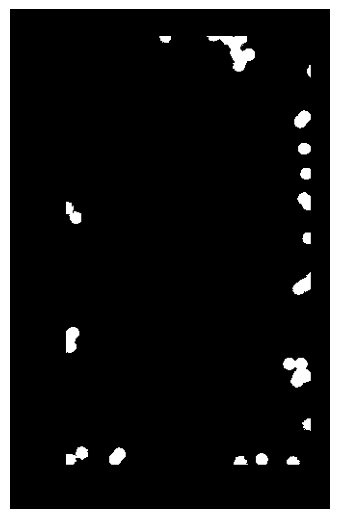

In [139]:
def frame_deleter(image):
    image[:28, :] = 0
    image[473:, :] = 0
    image[:, :58] = 0
    image[:, 312:] = 0
    return image

border_circles = cv2.convertScaleAbs(frame_deleter(cv2.connectedComponents(cirles_bin)[1] == 1) * 255)
# выделились кружочки + внешний белый фон, вокруг картинки, от фона надо избавиться

show_gray(border_circles)

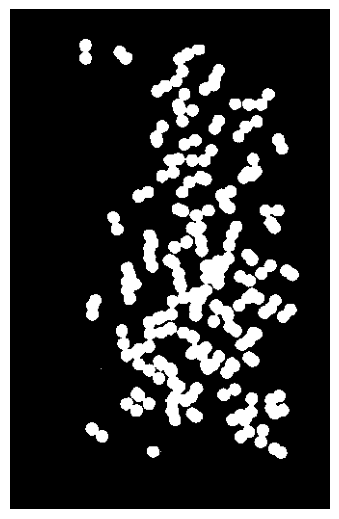

In [140]:
ovelapped_circles = cv2.convertScaleAbs(frame_deleter(cirles_bin - alone_circles - border_circles))
ovelapped_circles = cv2.threshold(ovelapped_circles,250,255,cv2.THRESH_BINARY)[1]    # после вычитания могли остаться следы alone_circles
show_gray(ovelapped_circles)

standing alone (red) : 46
border (green) : 18
ovelapped (blue) : 47


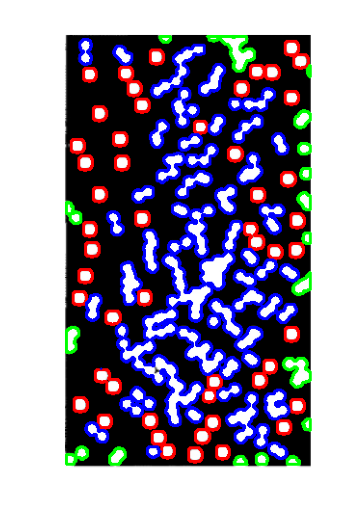

In [141]:
def color_circles(image_rgb, *components):
    lens = []
    for i, comp in enumerate(components):
        cnts, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        color_arr = [0, 0, 0]
        color_arr[i] = 255
        cv2.drawContours(image_rgb, cnts, -1, color_arr, 2)
        lens.append(len(cnts))
    print(f'standing alone (red) : {lens[0]}')
    print(f'border (green) : {lens[1]}')
    print(f'ovelapped (blue) : {lens[2]}')
    show_rgb(image_rgb)

@pyplot
def show_rgb(img, size=(10, 5)):
    plt.imshow(img)

circles_rgb = cv2.imread(str(sources_path / "circles.png"))
color_circles(circles_rgb, alone_circles, border_circles, ovelapped_circles)


**3. (5 баллов)** **Watershed**

* Возьмите изображения: *coins_1.jpg*, *coins_noize_1.jpg*
* Примените к ним алгоритм водораздела, чтобы посчитать монетки
* отсоритруйте монетки по размеру и у каждой моентки в центре впишите порядковое число

В сниппете кода содержится подсказка о том, какие функции стоит поприменять. 

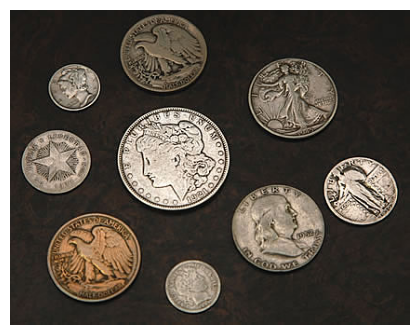

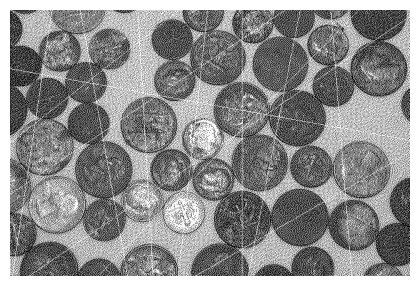

In [142]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import scipy
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label
from cv2 import pyrMeanShiftFiltering   # mean
coins_1 = cv2.imread(str(sources_path / "coins_1.jpg"))
show_bgr(coins_1, size=(4, 5))
coins_2 = cv2.imread(str(sources_path / "coins_noize_2.jpg"))
show_bgr(coins_2, size=(4, 5))

/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


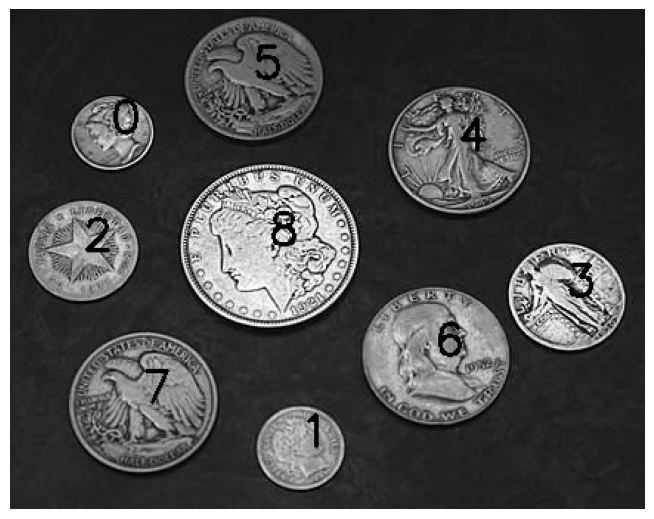

In [143]:
gray_coins_1 =  cv2.cvtColor(coins_1, cv2.COLOR_BGR2GRAY)
def watershed_coins(image):
    img = cv2.threshold(image,45,255,cv2.THRESH_BINARY)[1]
    distance = distance_transform_edt(img)
    coords = peak_local_max(distance, min_distance=40, labels=img) 
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, num = label(mask)
    labels = watershed(-distance, markers, mask=img)
    
    labels[labels!=0] = 255
    labels = cv2.morphologyEx(np.uint8(labels), cv2.MORPH_CLOSE, np.ones((5, 5)))
    labels = cv2.Canny(np.uint8(labels), 30, 150)
    cnt, _ = cv2.findContours(labels, cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
    cnt.sort(key=lambda x: len(x))
    img = image.copy()
    for i, cont in enumerate(cnt):
        M = cv2.moments(cont)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        img = cv2.putText(img, str(i), org=(cX, cY), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                   fontScale=1, color=(0, 0, 0), thickness=2)
    
    show_gray(img)



watershed_coins(gray_coins_1)

# Фильтры габора

**4. (15 баллов)**  

Реализуйте функцию, которая построит банк фильтров Габора по входящим аргументам n, m. 
* n – число различных частот в дипазоне (0; max_freq]
* m - число различных напралений в диапазоне [0; Pi)

Продемонструйте, что предложенные фильтры более-менее плотно заполняют частотное просранство. Для этого переведите все фильтры в частотное пространство и отобразите все их одновременно на одной картинке. 

Реализуйте интерактивное demo в котром будут два слайдера, один отвечает за разные разные частоы, другой за разные направления. Выведите 3 изображения:
* Вид фильтра в пространстве изображений
* Вид Фильтра в частотном пространстве
* Результат применения фильтра к $lena.jpg$

In [144]:
def many_plot(*images, n=10):
    plt.figure(figsize=(n, n))
    for i, x in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(x, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
    # plt.show()

In [145]:
def gabor(x, y, w0=45, theta=-45, P=0, x0=0, y0=0, a=1/10, b=1/15, K=1, F0=0.2):
    w0_ = (w0 + 90) * np.pi / 180
    theta_ = theta * np.pi / 180
    a_r = a**2 * ((x-x0) * np.cos(theta_) + (y-y0)*np.sin(theta_)) ** 2
    b_r = b**2 * (-(x-x0) * np.sin(theta_) + (y-y0)*np.cos(theta_)) ** 2
    gauss_kernel = K * np.exp(-np.pi * (a_r + b_r))
    angle = 2 * np.pi * F0 * (np.cos(w0_) * x + np.sin(w0_) * y) + P
    return gauss_kernel * np.array([np.cos(angle), np.sin(angle)])

In [146]:
size = 16
a=1/5
b=1/4
F0=0.15

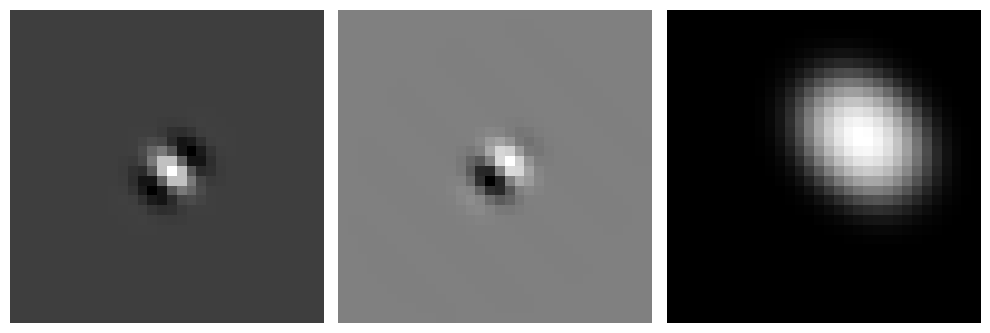

In [147]:
gabor_image = np.array([gabor(x, y, a=a, b=b, F0=F0) \
                        for x in range(-size, size) for y in range(-size, size)]).reshape(2*size, 2*size, 2)

gabor_fourier = cv2.dft(np.float32(gabor_image))
magnitude_new = np.fft.fftshift(np.log(1 + cv2.magnitude(gabor_fourier[:, :, 0], gabor_fourier[:, :, 1])))
many_plot(gabor_image[:, :, 0], gabor_image[:, :, 1], magnitude_new)

In [148]:
max_freq = 360
n = 20
m = 10

Покрытие частотного пространства:

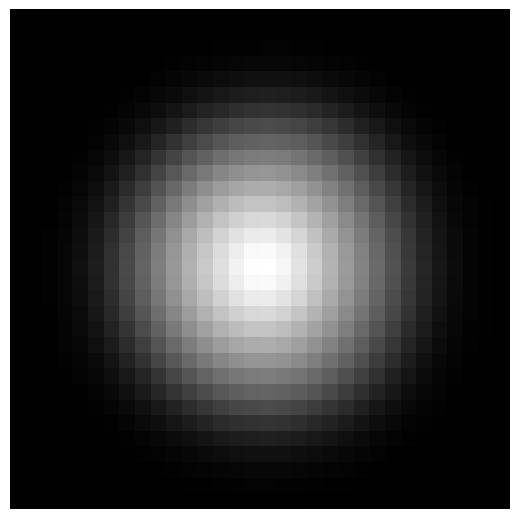

In [149]:
def cover(n, m, size, a, b, F0):
    all_magnitudes = np.zeros((2*size, 2*size))
    for w0 in [max_freq/(n+1)*i for i in range(1, n+1)]:
        for theta in [180/(m+1)*j for j in range(m)]:

            gabor_image = np.array([gabor(x, y, w0=w0, theta=theta, a=a, b=b, F0=F0) \
                                for x in range(-size, size) for y in range(-size, size)]).reshape(2*size, 2*size, 2)
            gabor_fourier = cv2.dft(np.float32(gabor_image))
            magnitude_new = np.fft.fftshift(np.log(1 + cv2.magnitude(gabor_fourier[:, :, 0], gabor_fourier[:, :, 1])))
            all_magnitudes += magnitude_new
    return all_magnitudes


all_magnitudes = cover(n, m, size, a=a, b=b, F0=F0)
show_gray(all_magnitudes)

In [150]:
lena = cv2.imread(str(sources_path / "lena.jpg"), 0)

interactive(children=(FloatSlider(value=45.0, description='w0', max=360.0, min=17.142857142857142, step=17.142…

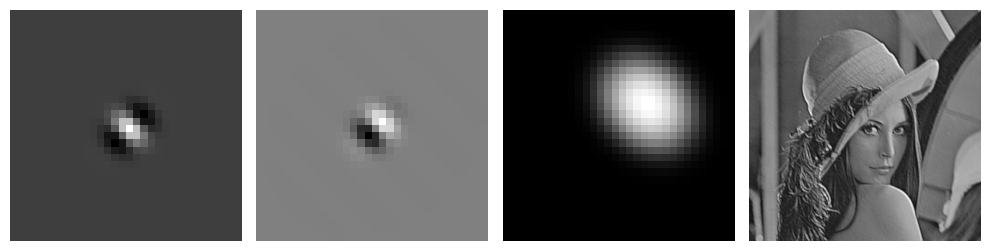

In [151]:
from ipywidgets import interact

@interact(w0=(max_freq/(n+1), max_freq, max_freq/(n+1)), theta=(0, 180*m/(m+1), 180/(m+1)))
def gabor_action(w0=45, theta=-45):
    gabor_image = np.array([gabor(x, y, w0=w0, theta=theta, a=a, b=b, F0=F0) \
                                for x in range(-size, size) for y in range(-size, size)]).reshape(2*size, 2*size, 2)
    gabor_fourier = cv2.dft(np.float32(gabor_image))
    magnitude_new = np.fft.fftshift(np.log(1 + cv2.magnitude(gabor_fourier[:, :, 0], gabor_fourier[:, :, 1])))
    
    lena_real = cv2.filter2D(lena, ddepth=cv2.CV_32F, kernel=gabor_image[:, :, 0])
    lena_im = cv2.filter2D(lena, ddepth=cv2.CV_32F, kernel=gabor_image[:, :, 1])
    lena_magnitude = cv2.magnitude(lena_real, lena_im)
    many_plot(gabor_image[:, :, 0], gabor_image[:, :, 1], magnitude_new, lena_magnitude)
    # many_plot(lena_magnitude)
    

gabor_action()

# Цветовые гистрограммы.

**5. (15 баллов)**

Надо реализовать функцию, которая принимет на вход:

* список дескрипторов (**id**, и сам дескриптор) 
* количество максимально похожих для вывода **n**
* функцию сранения дескрипторов

и отдает **n** пар **id** максимально похожих изображений.

Посмотрите на изображения в папке *Corel*. Посчитайте гистограммы изображений. Выведите на экран 20 пар изображений с максимально похожими гистограммами, которые получаются для лучшей комбинации. В этом задании надо попробовать:
* различные цветовые пространства (RGB, HSV, CIELab)
* различные способы разбиения на бины (разное количество для каждой характеристики, joint_vs_marginal)
* различные метрики сравнения $L_2$, $\chi^2$, пересечение гистограм

Постройте сводную таблицу-отчет в которою впишите, сколько похожих пар получилось для каждого эксперимента. Проведите не менее 8 экспериментов и напишите какие-нибудь выводы

# Гистограмма градиентов

**6. (10 баллов)**

Реализуйте функцию вычисления $HOG$ дескриптора для изображения, которая принимает на вход размер сетки. Визуализируйте полученный дескриптор на изображении *susi_example.jpg* с сетками размером 10x8 и 5x4. Просканируйте скользящим окном изображение *susi_gallery.jpg* и подсветите все области, дексриптор которых поход на дескриптор *susi_example.jpg*. В идеальном случае мы должны получить 3 изображения, для которых надо подобрать порог похожести:
* Та самая вырезанная сушина.
* Все суши с креветкой.
* Все суши, которые визуально похожи на суши с креветкой. 

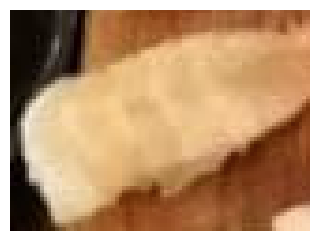

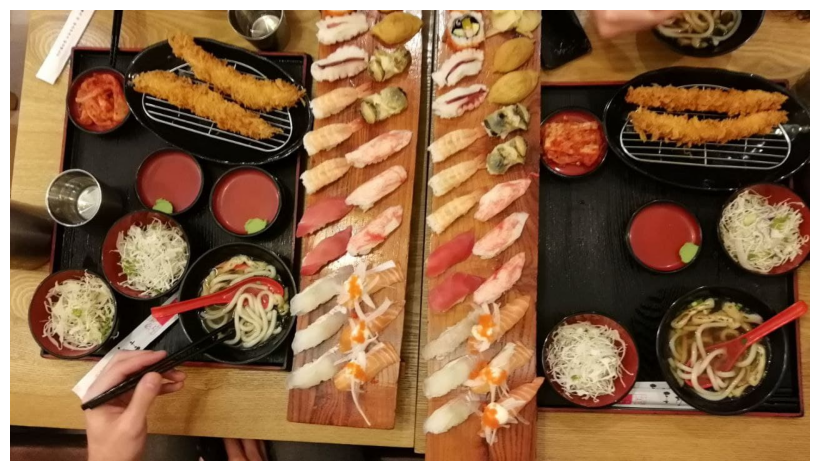

In [152]:
susi_example = cv2.imread(str(sources_path / "susi_example.jpg"))
show_bgr(susi_example, size=(3, 4))
susi_gallery = cv2.imread(str(sources_path / "susi_gallery.jpg"))
show_bgr(susi_gallery, size=(8, 16))

In [154]:
cell_size = [10, 8] 
block_size = [5, 4] 
nbins = 9

In [226]:
hog = cv2.HOGDescriptor(
    _winSize=(susi_example.shape[1] // cell_size[1] * cell_size[1], susi_example.shape[0] // cell_size[0] * cell_size[0]),
    _blockSize=(block_size[1] * cell_size[1], block_size[0] * cell_size[0]),
    _blockStride=(cell_size[1], cell_size[0]),
    _cellSize=(cell_size[1], cell_size[0]),
    _nbins=nbins)

example_hist = hog.compute(susi_example)
searches = []
for i in range(0, susi_gallery.shape[0] - susi_example.shape[0], 10):
    for j in range(0, susi_gallery.shape[1] - susi_example.shape[1], 8):
        current_image = susi_gallery[i: i + susi_example.shape[0], j: j + susi_example.shape[1]]
        current_hist = hog.compute(current_image)
        searches.append([i, j, np.sum(np.abs(current_hist - example_hist))])

searches.sort(key=lambda x: x[2])

In [254]:
def highlight(image, i, j, d=4):
    h, w = susi_example.shape[:2]
    res = image.copy()
    res[i: i + d, j: j + w, 1] = 255
    res[i: i + h, j: j + d, 1] = 255
    res[i + h: i + h + d, j: j + w, 1] = 255
    res[i: i + h, j + w: j + w + d, 1] = 255
    return res

def super_highlite(n):
    image = susi_gallery.copy()
    shown = []
    for i, j, _ in searches[:n]:
      flg = False
      for x, y in shown:
          if (abs(i - x) < susi_example.shape[0]) and (abs(j-y) < susi_example.shape[1]):
              flg = True
      if flg:
          continue
      image = highlight(image, i, j)
      shown.append((i,j))
    show_bgr(image)

Та самая сушина

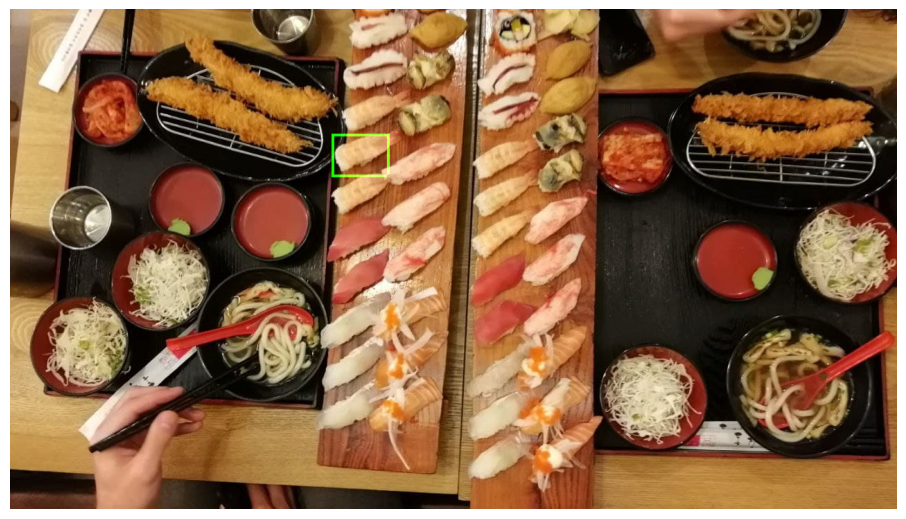

In [255]:
super_highlite(1)

Какие-то с креветкой, как первая

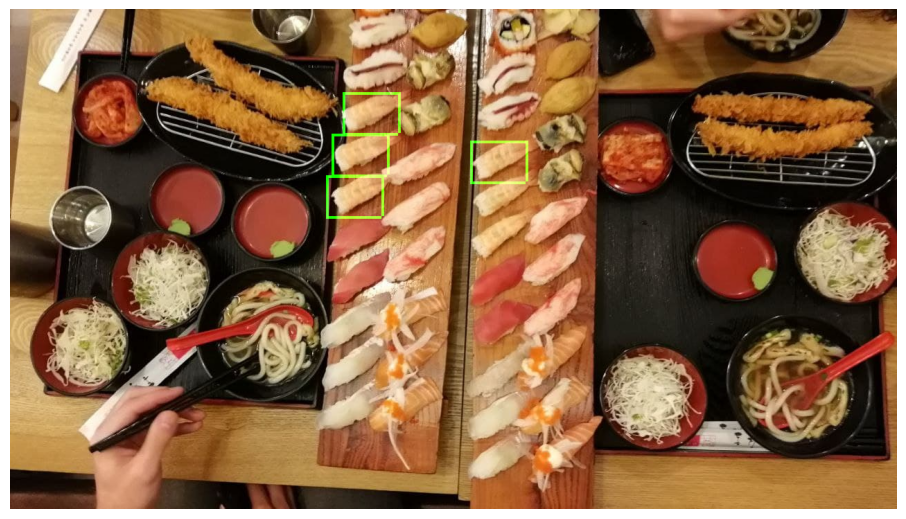

In [256]:
super_highlite(5)

Похожие на то, что с креветкой

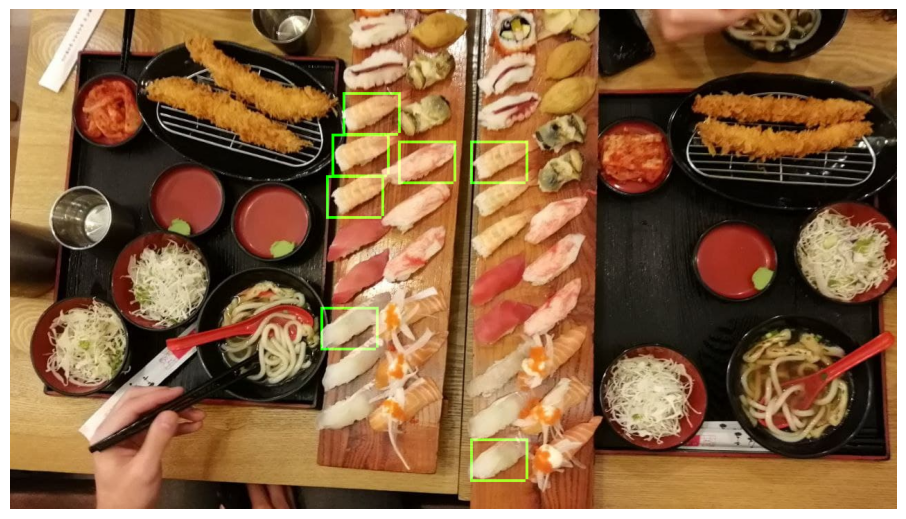

In [257]:
super_highlite(20)